In [1]:
import itertools
import os

from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.formula.api as smfa

from IPython.display import Image

plt.rcParams["figure.figsize"] = (12,8)

# FYS9555 Project 2 «Cosmic Rays»

## Victor Ananyev

## 1. Cosmic rays

*Cosmic ray measurements.* The presence of an ionizing radiation at the Earth’s surface was already recognized by Coulomb in 1785. More than a century later, Hess showed conclusively that the ionisation rate increases with altitude, suggesting that it has a cosmic origin. By the 1930s, the observations of the geomagnetic latitude effect by Clay and coincidence measurements using two Geiger-Muller counters by Bothe and 
Kohlhörster demonstrated that this ionizing radiation consists mainly of charged particles, coined later “cosmic rays”.

In the 1940s, measurements using cloud  chambers  and  photographic  plates  carried  by  balloons  into  the  stratosphere  showed  that cosmic rays (CRs) consist mainly of relativistic protons, with an admixture of heavier nuclei. The  existence  of  extensive air showers triggered by high-energy  CRs  was  established  by Kohlhörster, Auger, and their collaborators in the 1930s.

After the second world war, large detector  arrays  were  installed  to  measure  these  extensive  air  showers,  establishing  a  power  law $\frac{dN}{dE} \propto \frac{1}{E^α}$. In the following years, the M.I.T. group deployed at the Volcano Ranch an array of scintillation counters covering an area of $12~km^2$ which recorded in 1962 an air shower with energy around $10^{20}~eV$.  At present, the two largest arrays observing CRs are the Pierre Auger Observatory (PAO) located in Argentina covering an area of $3000~km^2$ and the Telescope Array (TA) in the USA covering $900~km^2$.  Both are hybrid experiments combining surface detectors to measure air showers on the ground and fluorescence detectors which can follow the longitudinal development of the showers in the atmosphere.

A summary of CR intensity measurements is shown in the figure below. In such figures, the particle intensity $I(E)$ is often multiplied by a power $α$ of the energy $E$ such that $E^α I(E)$ becomes approximately flat, making thereby structures in $I(E)$ more visible.

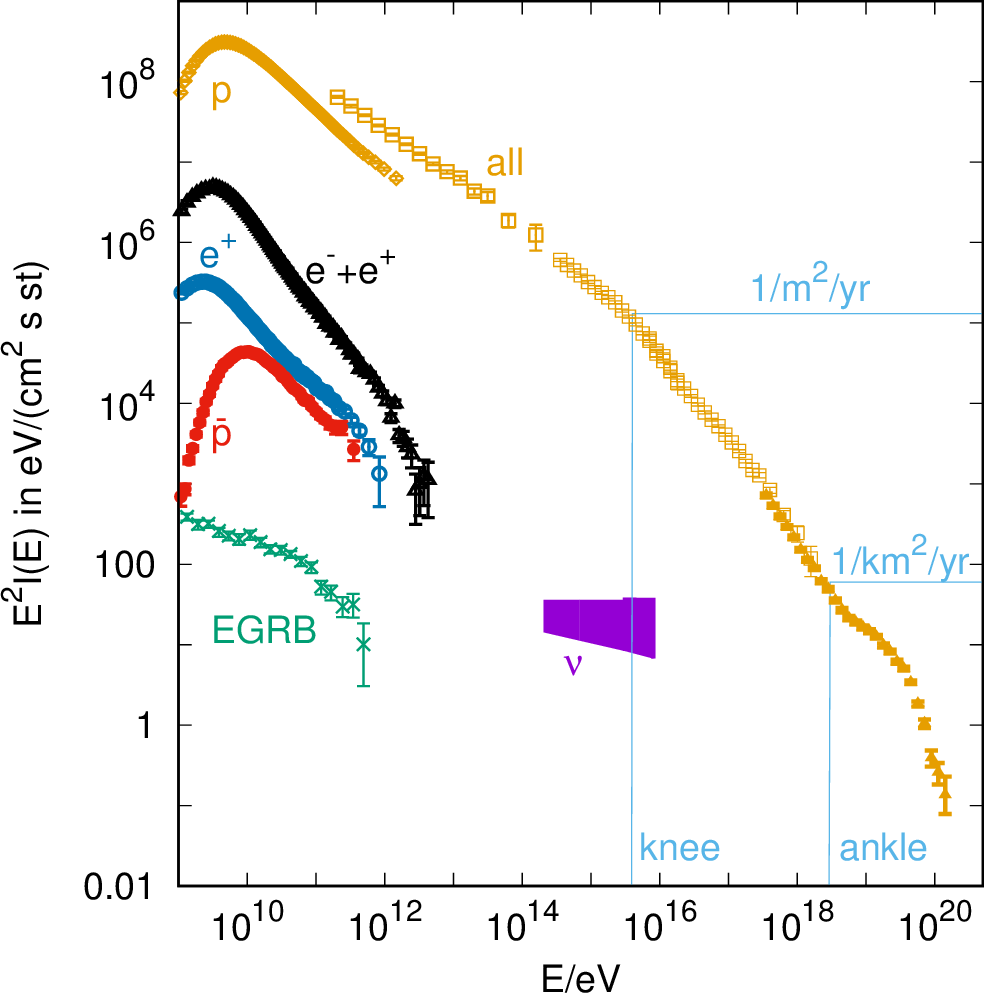

In [2]:
Image("img/overall.png", width="60%")

In the flux of CR nuclei, which is the dominating contribution to the total CR flux, additional to the CR knee another break at $3×10^{18}~eV$ called the ankle and a cut-off like feature around $10^{20}~eV$ are visible.  Below $20~GeV$, the CR spectrum is suppressed because the magnetic field embedded within the Solar wind plasma prevents that charged low-energy particles enter the Solar system.

The second most-prominent species in the CR flux are electrons which flux is reduced by a factor of order 100 relative to the one of nuclei.  The fluxes of their antiparticles, antiprotons and positrons, are of comparable magnitude and suppressed by two orders of magnitude relative to electrons. 

Since the maximal area of a balloon or satellite experiment is of the order of a few square meter, the energy $10^{14}~eV$ marks the end of direct detection experiments. These experiments have typically the ability to measure the charge of individual CRs and thus the fluxes of individual CR nuclei are relatively well-known up to this energy. At higher energies, the CR flux drops to a level which prohibits to collect them with high enough statistics using detectors of few $m^2$ size.  However, at these energies, the extensive showers of secondary particles initiated by CR primaries interacting in the atmosphere start to reach the ground. Detecting Cherenkov and fluorescence light of such showers in the atmosphere, as well  as  the  secondary particles on the ground allows one to reconstruct the energy and arrival direction of the primary CR rather precisely.

The determination of the primary mass has been, however, a challenging problem for these indirect measurements, although considerable progress has been made in the last 15 years.

*Astrophysics of cosmic rays.* In 1934, Baade and Zwicky suggested presciently that CRs draw their energy from supernovae explosions. Hiltner and Hall discovered in 1949 an ubiquitous magnetic field in the Milky Way through the polarisation of star light. In the same year, Fermi proposed his theory of CR acceleration by moving “magnetic clouds”, explaining for the first time how a power-law like energy spectrum can arise through the combined action of accelerationand  losses. One  might  view  this  year  as  the  birth  date  of  the  “astrophysics  of  cosmic  rays”, i.e. the research field studying the acceleration and propagation of cosmic rays. Five years later, Morrison, Olbert, and Rossi suggested that the path length of CRs in the Milky Way should be small relative to their interaction lengths, leading to the application of realistic diffusion models to the propagation of Galactic CRs. This approach was worked out then in detail in the classic book of Ginzburg and Syrovatskii. Fermi’s idea of second-order acceleration was developed further into the theory of diffusive shock acceleration around 1977. In this theory, the energy gain per cycle is linear in the shock velocity, while it is quadratic in the cloud velocity in Fermi’s original model. Consequently, diffusive shock acceleration leads to much larger maximal energies for the same acceleration time.  Therefore it is today considered as the leading explanation for the acceleration of CRs in a large variety of astrophysical environments, ranging from shocks in the Solar corona, pulsar winds, and supernova remnants up to active galactic nuclei and gamma-ray bursts. A crucial prediction of diffusive shock acceleration is the slope of the energy spectra $\frac{dN}{dE} \propto \frac{1}{E^β}$ of accelerated particles

Two additional constraints on potential CR sources apply to their *age* and their *compactness*:

* If the source is too compact, the strong magnetic field leads to too large energy losses, reducing the allowed area for $10^{20}~eV$ proton sources to the light-grey area shownin the Hillas plot.

* In the opposite case of a very extended source with a weak magnetic field, the acceleration time may exceed the age of the source. In the specific case of CRs accelerated by SN shocks, the maximum energy was estimated by Lagage and Cesarsky as 10 TeV, assuming that the magnetic field is pependicular to the shock and its strength close to the shock equals the ambient magnetic field, $B \approx 3~μG$. This result would exclude shock acceleration in SNRs as source of Galactic CRs up to the knee.

Going beyond the test-particle approximation for shock acceleration leads to two modifications: 

* First, the pressure of CRs modifies the shock profile, and as a result the CR spectra deviate from a simple power law and become concave.

* Second, and more importantly, the escape current of CRs leads to an efficient magnetic field amplification via the Bell instability, increasing thereby the possible maximal energies of CRs.

The theoretical suggestion of magnetic field amplification is supported by various observations: For instance, the analysis of the morphology of X-ray emissionclose to the outer shocks of SN1006 and Cas-A imply  that strong magnetic fields on the order of $100~μG$ are  needed  to  explain rapid synchrotron losses by high-energy  electrons.

The presence of stronger magnetic fields close to shocks re-opens the possibility that supernovae accelerate CRs up to the knee and beyond. Cosmic rays interacting with  gas or background  photons  produce  neutral and charged pions whose decays in turn lead to secondary high-energy photons and neutrinos. The combined study of potential CR sources using charged CRs together with photons and neutrinos has developed into the field of *multi-messenger astronomy*.  Moreover, there is a close relationship with searches for gravitational waves:  Many suggested CR sources tap their energy from the gravitational collapse of a compact object, which leads to the emission of gravitational waves. Vice versa it is expected that the merger of a binary system involving one or two neutron stars leads to the acceleration of high-energy particles, as it was observed for the first time in the case of GW170817: This event was observed extensively in the optical,  x-ray and gamma-ray part of the electromagnetic spectrum, with a spectrum characteristic for a short gamma-ray burst.

*Based on* https://arxiv.org/abs/1904.08160 . *Find more references in the text of the introduction there*

## 2. The POLA detectors

The scientific intent of the PolarquEEEst experiment is to measure the rate of cosmic rays at the sea level in a wide latitude range, expecially in the artic region where few measurements are available. Due to the shape of the Earth’s magnetic field in the artic regions, an increase of the cosmic ray flux with respect to low-latitude regions is expected. Moreover, starting from about 60°N another effect due to the solar wind is expected to produce a saturation on the flux, flattening the rate. Experimental measurements have been summarised by A. H. Compton in 1933 that confirm these  expectations. Figure below shows the  plot  made  by Compton of the intensity of the cosmic radiation at the sea level as a function of the latitude.

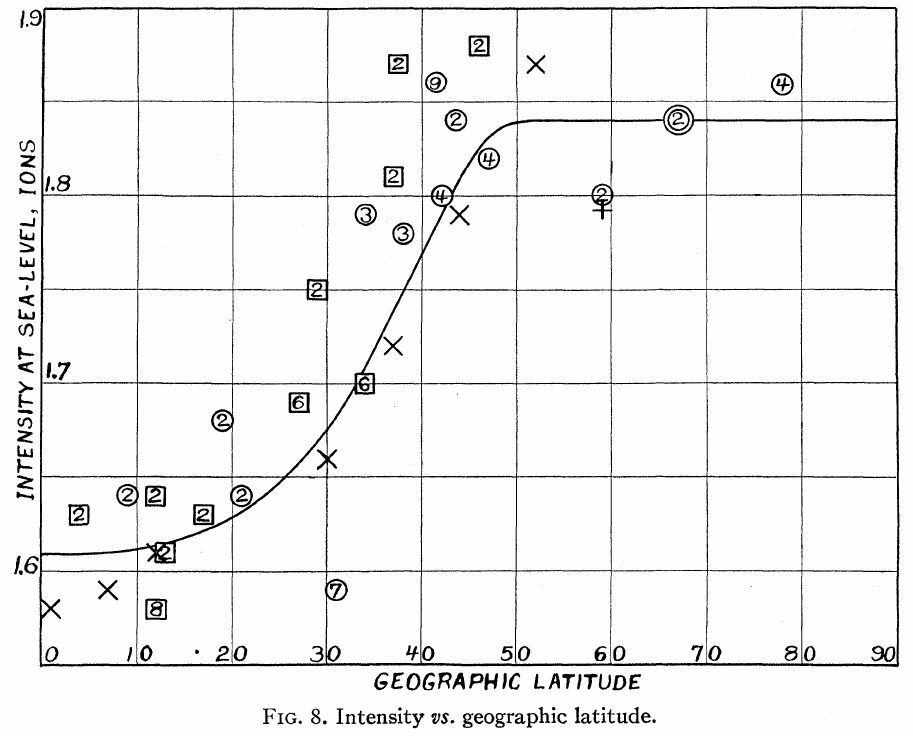

In [3]:
Image("img/compton-lat.png", width="60%")

*The PolarquEEEst detectors and experimental setup.* 

Each of the “POLA” detectors is made of:

* two floors of four tiles of **plastic scintillator** ($20×30×1~cm$ 3B400 Saint-Gobain), $11~cm$ apart in the vertical axis as shown in the figure

* the light-sensitive part of the device is enclosed with a **light-tight plastic box**.

* a pair of **silicon photomultipliers (SiPM)** is attached to each of the scintillator tiles and optically coupled by means of an optical gel in the positions highlighted in the figure (c)

The light produced by the passage of a charged particle through the scintillator is converted by SiPMs to an electric signal.

* eight **front-end boards**, each capable of handling two different SiPMs signals separately, are dedicated to discriminate this analogue signal (only signals above a certain configurable threshold are selected)

* the **trigger** and **read-out board (TRB)** is used to measure the time-over-threshold (ToT) of the signals discriminated by the front-end boards.

* the TRB is equipped with an Altera Cyclone 5 **FPGA**, workingat 100 MHz speed, that implements in firmware:

    * 16 time-to-digital converters (TDC)
    * the trigger logic and a high-resolution timer to put a time stamp to the detected events with a $10 ns$ resolution

* the trigger and read-out board is also provided with a u-blox EVK-M8GZOE-0 **GPS/GLONASS receiver** that allows:
    * the positioning and the time synchronisation of the POLA detectors
    * sensors for continuously monitor the tilt in the three axes (3D gyroscope)
    * monitor the heading (3D compass)
    * monitor the temperature inside the scintillator and the electronic boxes and outside the detector separately
    * monitor the atmospheric pressure and humidity

* Along with the FPGA TDCs, an **HPTDC board**, mounted on a mezzanine of the TRB, is devotedto the digitisation of front-end discriminated signals for redundance and cross check
* **Raspberry Pi 3** model B+ for data acquisition and transfer. 

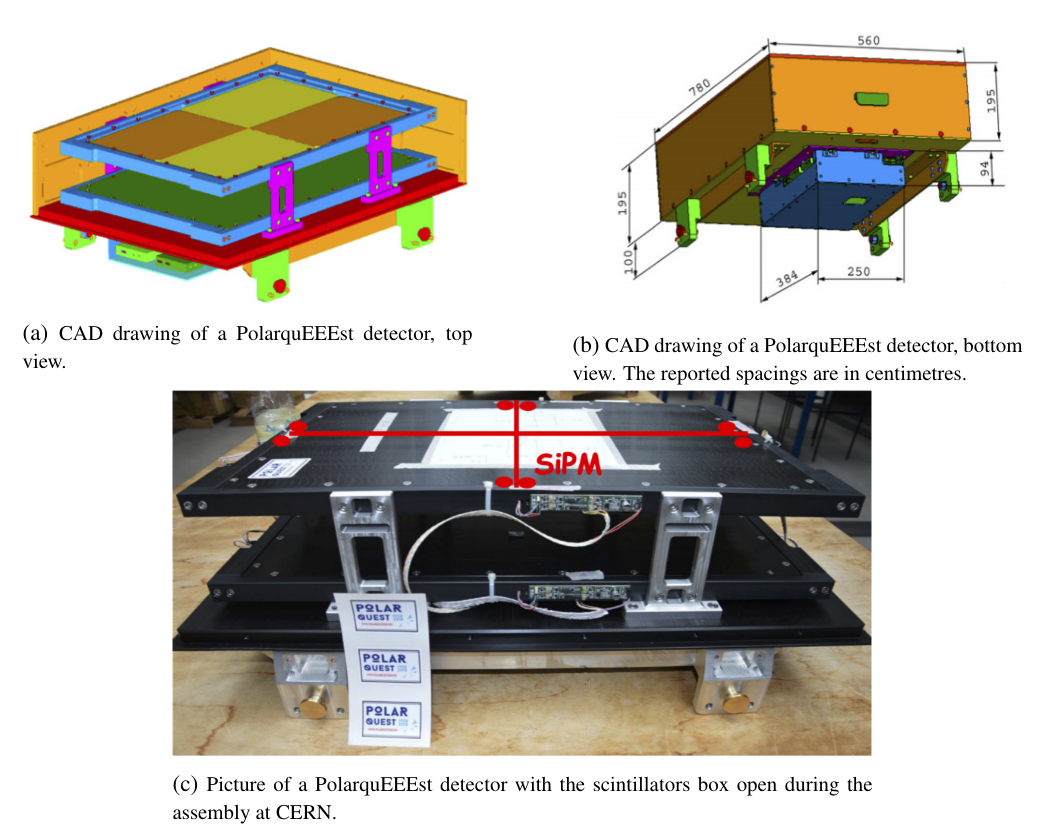

In [4]:
Image("img/pola-struct.png", width="60%")

The trigger condition is set by the coincindence within $10~ns$ of the signal from the pair of SiPMs of one tile, in the same coincidence window with a signal of any other SiPM on the other plane. A triggered event contains all the SiPM hits within the trigger window and contains their ToTs and the time information of the first triggered hit.

The data acquisition and storage to file (DAQ) are performed by a Python script running on a Raspberry Pi 3 model B+ which is connected to the TRB via a serial connection. Another Python script, the PolarquEEEst DAQ Control and Monitor, allows to control and monitor the DAQ system through a web-based user interface written in HTML5 and JavaScript. The acquired data are continuously sent via Internet to the INFN-CNAF computing centre, located in Bologna, Italy, for permanent storage, analysis and monitor. During the PolarQuest 2018 mission, the acquired data files were stored on the microSD card of the Raspberry Pi because the $10~W$ limited power budget available on the boat prevented the use of a more robust, yet power hungry, storage solution. For the current phase, PolarquEEEst 2019, a $2~TB$ external hard drive has been attached to each of the POLA detectors to extend the buffer of local data in case of possible Internet connection black-outs.

*Based on conference proceedings:* https://pos.sissa.it/358/371/pdf

### 2.1 Scintillators and photomultipliers

A *scintillator* is a material that exhibits scintillation, the property of luminescence, when excited by ionizing radiation. Luminescent materials, when struck by an incoming particle, absorb its energy and scintillate (i.e. re-emit the absorbed energy in the form of light).

A *scintillation detector* or scintillation counter is obtained when a scintillator is coupled to an electronic light sensor such as:

* photomultiplier tube (PMT)

    PMTs absorb the light emitted by the scintillator and re-emit it in the form of electrons via the *photoelectric effect*. The subsequent multiplication of those electrons (sometimes called photo-electrons) results in an electrical pulse which can then be analyzed and yield meaningful information about the particle that originally struck the scintillator. Vacuum photodiodes are similar but do not amplify the signal while silicon photodiodes, on the other hand, detect incoming photons by the excitation of charge carriers directly in the silicon.


* silicon photomultiplier

    Silicon photomultipliers consist of an array of photodiodes which are reverse-biased with sufficient voltage to operate in avalanche mode, enabling each pixel of the array to be sensitive to single photons.


* photodiode



**More on avalanche mode in diods**

The simplest device working in avalanche mode is a *single-photon avalanche diode* (SPAD). SPAD is a solid-state photodetector in which a photon-generated carrier (via the internal photoelectric effect) can trigger a short-duration but relatively large avalanche current. This avalanche is created through a mechanism called impact ionization, whereby carriers (electrons and/or holes) are accelerated to high kinetic energies through a large potential gradient (voltage). If the kinetic energy of a carrier is sufficient (as a function of the ionization energy of the bulk material) further carriers are liberated from the atomic lattice. The number of carriers thus increases exponentially from, in some cases, as few as a single carrier. 

*Source: Wikipedia*

## 3. Data analysis

In [5]:
DATA_DIR = "data"

In [6]:
CORRUPTED_TRENDING_COLS = set(['RateTrackEventsTheta0_10',
                               'RateTrackEventsTheta10_20',
                               'RateTrackEventsTheta20_30',
                               'RateTrackEventsTheta30_40',
                               'RateTrackEventsTheta40_50',
                               'RateTrackEventsTheta50_60',
                               'RateTrackEventsTheta60_90',
                               'AvTOTBot', 'AvTOTMid', 'AvTOTTop'])

Read the data into dataframes. For `Trending` we noticed that some files miss columns `CORRUPTED_TRENDING_COLS`. We decided to normalize all the data, and drop these columns from everywhere (since we don't plan to use them in the project anyways).

In [7]:
def struct_files(files):
    header = None
    weather = None
    trending = None
    for f in files:
        if not f.endswith(".csv"):
            continue
        if "Header" in f:
            header = f
        elif "Weather" in f:
            weather = f
        elif "Trending" in f:
            trending = f
    return header, weather, trending

In [8]:
def assemble_cuts(df, cut_list):
    res = []
    for cut_name in cut_list:
        cut = CUTS
        for path_part in cut_name.split("."):
            cut = cut[path_part]
        res.append(cut(df))
    return np.any(res, axis=0)

In [9]:
# which lines to drop. we apply these cuts occasionally in different combinations,
# each time mentioning that we apply them.

CUTS = {
    "runs": {
        "small_event_number": lambda df: df["NumEvents"] < 12000,
        "run_time_too_long": lambda df: ((df["RunStop"] - df["RunStart"]) > 1000000),
        "run_time_too_short": lambda df: ((df["RunStop"] - df["RunStart"]) < 60*10),
        "pola3_perturb_time": lambda df:   (df["RunNumber"] < 3661E5) \
                                         & (df["RunNumber"] > 3654E5) \
                                         & (df["telescope"] == "POLA-03"),
        "pola1_time_misses": lambda df:   (df["RunNumber"] < 3663E5) \
                                         & (df["RunNumber"] > 3655E5) \
                                         & (df["telescope"] == "POLA-01"),
    }
}

In [10]:
def parse_header(path, tid):
    read_h = pd.read_csv(path, header=0).rename(columns={"#RunNumber": "RunNumber"})
    read_h["telescope"] = pd.Series(np.full_like(read_h["telescope"], tid))
    return read_h

In [11]:
def parse_weather(path):
    read_w = pd.read_csv(path, header=0).rename(columns={"#Seconds": "Seconds"})
    return read_w

In [12]:
def parse_events(path, runs):
    read_t = pd.read_csv(path, header=0).rename(columns={"#BinStart": "BinStart"})
    
    corrupted = CORRUPTED_TRENDING_COLS - set(read_t.columns)
    cols_to_drop = set(read_t.columns) & CORRUPTED_TRENDING_COLS
    read_t.drop(columns=cols_to_drop, inplace=True)
    read_t = pd.merge(runs[["telescope", "UniqueRunId"]], read_t, on="UniqueRunId", how="left")
    
    return read_t, corrupted

In [13]:
class CorruptedRecordException(Exception):
    pass

In [14]:
def parse_runs(header_f, weather_f, resource):
    header_d = parse_header(header_f, resource)
    if header_d.shape[0] == 0:
        raise CorruptedRecordException(f"Corrupted header: {h}")

    weather_d = parse_weather(weather_f)
    if weather_d.shape[0] == 0:
        raise CorruptedRecordException(f"Corrupted weather: {w}")

    runs = pd.merge(header_d, weather_d, on="UniqueRunId", how="left", validate="one_to_one")

    header_missing_weather = np.count_nonzero(~np.isin(header_d["UniqueRunId"], weather_d["UniqueRunId"]))
    if header_missing_weather:
        print(f"Header missing Weather: {header_missing_weather}. {header_f.split('/')[-1]}")

    run_cuts = assemble_cuts(runs, ["runs.small_event_number", 
                                    "runs.run_time_too_long",
                                    "runs.run_time_too_short"])
    
    return runs[~run_cuts]

We now read the data traversing all the subdirs of the DATA_DIR, we pick all the csv inputs and concat them. We also apply cuts:

* runs.small_event_number — to remove runs with too few events
* runs.run_time_too_long — to remove too long runs
* runs.run_time_too_short — to remove too short runs

We also notify when encounter events without some columns. We name them "corrupted"

In [15]:
data_map = {"Runs": [], "Events": []}


for resource in ["POLA-01", "POLA-02", "POLA-03"]:
    for root, dirs, files in os.walk(os.path.join(DATA_DIR, resource)):
        if not files:
            continue
        if len(files) != 3:
            print(f"Suspicious data in {root}")
        h, w, t = struct_files(files)
        
        try:
            runs = parse_runs(os.path.join(root, h),
                              os.path.join(root, w),
                              resource)
            data_map["Runs"].append(runs)
        except CorruptedRecordException as e:
            print(e)
            continue
        
        events, events_corrupted = parse_events(os.path.join(root, t), runs)
        data_map["Events"].append(events)
        if events_corrupted:
            print(f"Corrupted events: ts {events['BinStart'].iloc[0]} - {events['BinEnd'].iloc[-1]}. {root}/{t}")
            
        events_without_header = np.count_nonzero(~events["UniqueRunId"].isin(runs["UniqueRunId"]))
        if events_without_header:
            print(f"There are events without header: {events_without_header}. {root}/{t}")

Corrupted events: ts 364521650.0 - 364607881.0. data/POLA-01/2018-07-21/POLA-01_2018-07-21_2018-07-21_summary_Trending.csv
Corrupted events: ts 364694646.0 - 364852038.0. data/POLA-02/2018-07-24/POLA-02_2018-07-23_2018-07-24_summary_Trending.csv
Corrupted events: ts 364522419.0 - 364608495.0. data/POLA-02/2018-07-21/POLA-02_2018-07-21_2018-07-21_summary_Trending.csv
Corrupted events: ts 364954724.0 - 365116627.0. data/POLA-02/2018-07-27/POLA-02_2018-07-26_2018-07-27_summary_Trending.csv
Corrupted events: ts 364781126.0 - 364934932.0. data/POLA-02/2018-07-25/POLA-02_2018-07-24_2018-07-25_summary_Trending.csv
Corrupted events: ts 364608549.0 - 364694595.0. data/POLA-02/2018-07-22/POLA-02_2018-07-22_2018-07-22_summary_Trending.csv
Corrupted events: ts 364694646.0 - 364781077.0. data/POLA-02/2018-07-23/POLA-02_2018-07-23_2018-07-23_summary_Trending.csv
Corrupted events: ts 364867798.0 - 365031132.0. data/POLA-02/2018-07-26/POLA-02_2018-07-25_2018-07-26_summary_Trending.csv
Corrupted events

In [16]:
runs = pd.concat(data_map["Runs"]).sort_values("RunNumber", axis="index").reset_index(drop=True)
events = pd.concat(data_map["Events"]).sort_values(["UniqueRunId", "BinStart"], axis="index").reset_index(drop=True)

Quality checks and alignment checks for `Header` and `Weather` timestamps. It turns out that there are 46 of ~13500 rows that are missaligned by 1 or 2 seconds. Good thing to be aware of.

In [17]:
# total number of events
print("Runs: ", runs.shape[0])

# how many runs for tracking do we have?
print("Runs for tracking: ", np.unique(events["UniqueRunId"]).shape)

# test RunDuration consistency
assert np.all(np.isclose(runs["RunStop"] - runs["RunStart"], runs["RunDuration"]))

# how many timestamp misalignments are there?
mask = (runs["RunNumber"] != runs["Seconds"])
(runs[mask]["Seconds"] - runs[mask]["RunNumber"]).describe()

Runs:  13036
Runs for tracking:  (8120,)


count    46.000000
mean      1.021739
std       0.147442
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
dtype: float64

`RunNumber` (form header) is almost the same as `Seconds` (from weather), and apparently means a moment of measuring the weather for specific run. `RunStart` is an exact time of run start. We see that there was a region between 365.5-366.5 MegaSeconds($10^6 s \approx 10~days$), where we've got weather measurements delayed (why?). If converted to real world dates, the timerange of the artifact corresponds to 1-10 Aug 2018.

On the plot below we show how difference between `RunNumber` and `Seconds` depends on `RunNumber` (red line), as well as the difference between `RunNumber` and `RunStart` (color per telescope). We can see that only POLA-01 has significant amount of misses. Gray dashed lines show the region we include into cuts, named: runs.pola1_time_misses

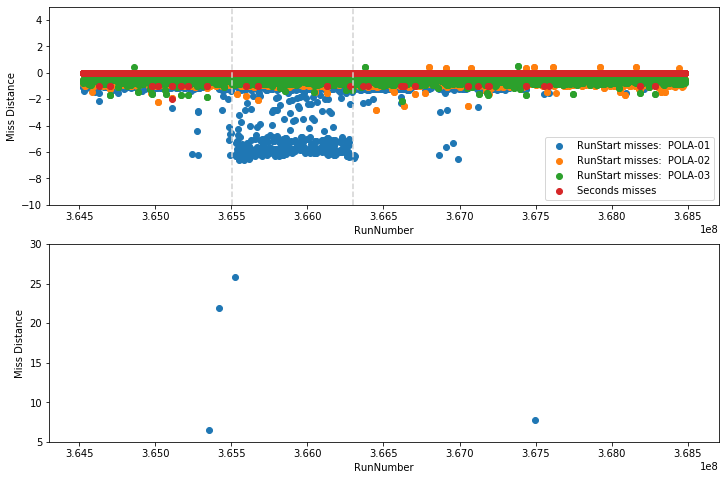

In [18]:
def plot_misses(axes, runs):
    ax = axes[0]
    runs.groupby("telescope", group_keys=True).apply(lambda tsc: \
        ax.scatter(tsc["RunNumber"], tsc["RunNumber"]-tsc["RunStart"], label=f"RunStart misses:  {tsc['telescope'].iloc[0]}")
    )
    ax.scatter(runs["RunNumber"], runs["RunNumber"]-runs["Seconds"], label=f"Seconds misses")
    ax.legend()
    ax.set_xlabel("RunNumber")
    ax.set_ylabel("Miss Distance")
    ax.set_ylim([-10, 5]);
    
    misses = runs[assemble_cuts(runs, ["runs.pola1_time_misses"])]
    ax.axvline(misses.iloc[0]["RunNumber"], ls="--", color="lightgray")
    ax.axvline(misses.iloc[-1]["RunNumber"], ls="--", color="lightgray")
    
    ax = axes[1]
    runs.groupby("telescope", group_keys=True).apply(lambda tsc: \
        ax.scatter(tsc["RunNumber"], tsc["RunNumber"]-tsc["RunStart"], label=f"RunStart misses:  {tsc['telescope'].iloc[0]}")
    )
    ax.set_xlabel("RunNumber")
    ax.set_ylabel("Miss Distance")
    ax.set_ylim([5, 30]);

fig, ax = plt.subplots(2)
plot_misses(ax, runs)

In [19]:
def binned_agg(df, xlabel, ylabel, agg, binsize, groups="telescope", agg_err=None):
    if agg_err is None:
        def error_func(x):
            return np.sqrt(np.mean((x - agg(x))**2))
    else:
        def error_func(x):
            return agg_err(x)
    def agg_func(x):
        # pandas is buggy with lambdas, they are unnamed :(
        return agg(x)
    
    def process_group(group_df):
        bins = np.arange(df[xlabel].values.min(), df[xlabel].values.max() + binsize/2, binsize)
        return group_df.set_index(xlabel)[[ylabel]] \
            .groupby(lambda idx: bins[np.searchsorted(bins, idx, side="right") - 1]) \
            .agg(**{
                ylabel: (ylabel, agg_func),
                f"{ylabel}_err": (ylabel, error_func)
            }).rename_axis(index={None: xlabel})
    
    if groups is not None:
        means = df.groupby(groups).apply(process_group)
    else:
        means = process_group(df)
        
    return means

In [20]:
tsc_color_map = {
    "POLA-01": plt.get_cmap("tab10")(0),
    "POLA-02": plt.get_cmap("tab10")(1),
    "POLA-03": plt.get_cmap("tab10")(2),
}

### 3.1 Environmental conditions

First of all, we want to look at the descriptive statistics for `IndoorTemperature`. We build the table for `IndoorTemperature` binned with time-step 10 minutes. We take the data from `events` set, which has more detailed time info for weather conditions.

Error is estimated as a standrd deviation from mean within each bin.

In [21]:
binned_agg(events, "BinStart", "IndoorTemperature", np.mean, 60*10).groupby("telescope").describe()

IndoorTemperature                                           \
                      count       mean       std       min       25%   
telescope                                                              
POLA-01              5161.0  25.356046  2.789492  17.34211  23.40022   
POLA-02              6453.0  25.058713  0.135105  24.64132  24.96511   
POLA-03              6455.0  33.355453  0.842570  29.09589  33.04969   

                                          IndoorTemperature_err            \
                 50%        75%       max                 count      mean   
telescope                                                                   
POLA-01    25.171057  27.370610  32.47807                5161.0  0.049289   
POLA-02    25.060340  25.155570  25.49840                6453.0  0.018011   
POLA-03    33.591930  33.846729  36.75874                6455.0  0.037423   

                                                                 
                std  min  25%           50%       75%       max  
telescope                                                        
POLA-01    0.119338  0.0  0.0  0.000000e+00  0.029824  1.407898  
POLA-02    0.031326  0.0  0.0  3.552714e-15  0.027993  0.217674  
POLA-03    0.091127  0.0  0.0  7.105427e-15  0.037084  1.180435

Here we show plots for IndoorTemperature, OutdoorTemperature and Pressure depending on time and a telescope. From the plots we can see that, as expected, `POLA-01` has very variable measures because it is drifting through the ocean. Errorbars are computed as a standard deviation from the mean.

What is also interesting, is that the artifact we saw in `RunStart misses` plot above (for POLA-01) was happening close to the time region we see here, but for POLA-03. Mystery. This region we denote as: runs.pola3_perturb_time in the cuts list


In [22]:
def plot_weather(ax, col, binsize):
    binned_agg(events, "BinStart", col, np.mean, binsize) \
        .groupby(level=0) \
        .apply(lambda tsc: \
            ax.errorbar(x=tsc.index.get_level_values(1),
                        y=tsc[col],
                        yerr=tsc[f"{col}_err"],
                        color=np.array(tsc_color_map[tsc.index.get_level_values(0)[0]]),
                        ecolor=np.array(tsc_color_map[tsc.index.get_level_values(0)[0]])*0.8,
                        label=tsc.index.get_level_values(0)[0],
                        fmt=".")
        )
    ax.legend()
    ax.set_ylabel(col);
    ax.set_xlabel(f"BinStart, binsize={binsize}");
    ax.axvline(runs[assemble_cuts(runs, ["runs.pola3_perturb_time"])]["Seconds"].values[0], ls="--", color="lightgray")
    ax.axvline(runs[assemble_cuts(runs, ["runs.pola3_perturb_time"])]["Seconds"].values[-1], ls="--", color="lightgray")

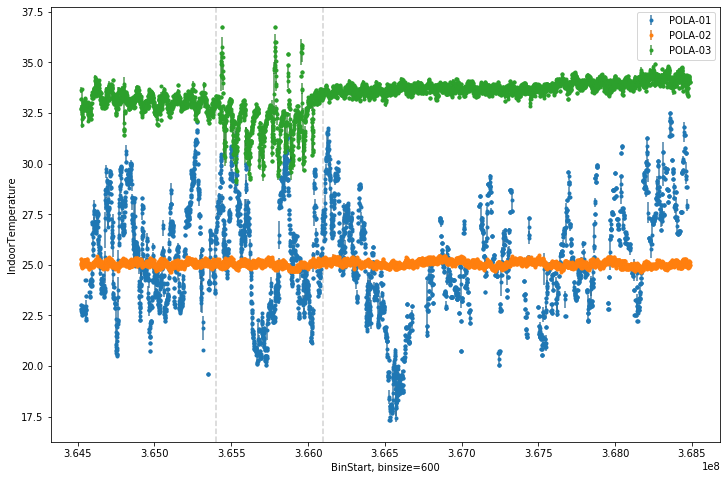

In [23]:
fig, ax = plt.subplots()
plot_weather(ax, "IndoorTemperature", 600)

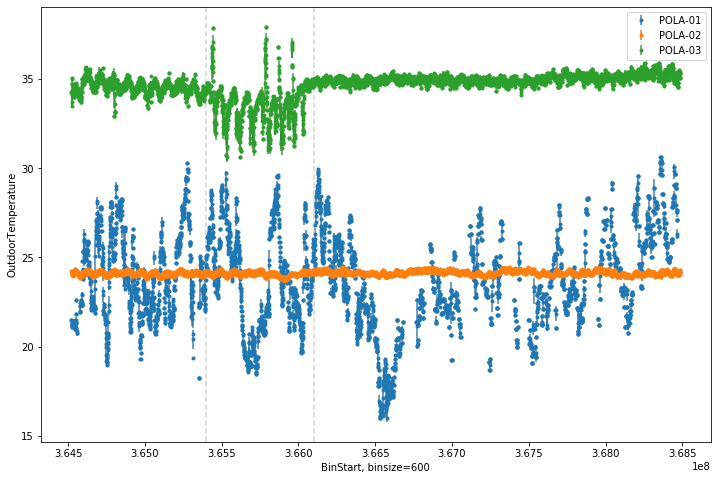

In [24]:
fig, ax = plt.subplots()
plot_weather(ax, "OutdoorTemperature", 600)

Finally, pressure plots show that while pressure conditions are quite similar for POLA-01 and POLA-02, since POLA-03 is located 250m heigher, POLA-03 shows significant pressure drop. That's why in the following steps, to conduct a collective study of data from all the telescopes, we'll have to introduce barometric correction. Errorbars are also present here, but they are quite small, the pressure doesn't vary a lot over 10 minutes time period.

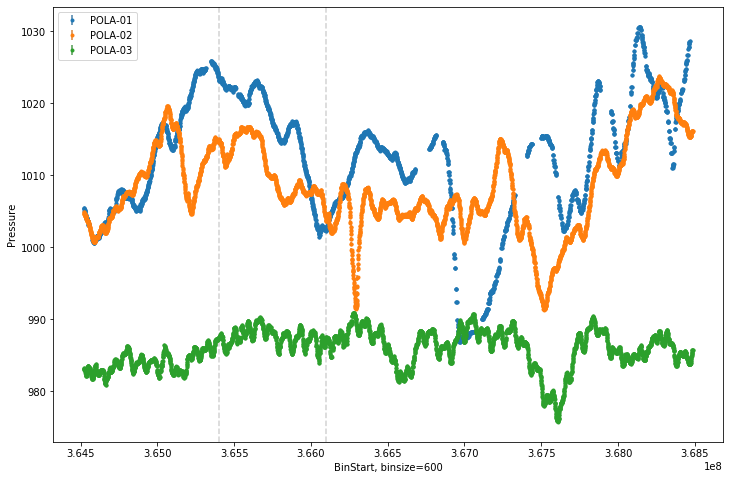

In [25]:
fig, ax = plt.subplots()
plot_weather(ax, "Pressure", 600)

### 3.2 Particle raw rate

As usual, we start from having a brief look at the data. Here are stats for `RunDuration` per telescope

In [26]:
runs.groupby("telescope").apply(lambda x: (x["RunDuration"]).describe())

RunDuration,count,mean,std,min,25%,50%,75%,max
telescope,,,,,,,,
POLA-01,2144.0,1375.945432,339.154096,611.045794,1192.727826,1211.364285,1262.869318,2150.878952
POLA-02,5778.0,1188.159916,59.175409,600.270483,1186.452713,1195.715225,1206.518553,1323.544574
POLA-03,5114.0,1353.008754,68.360951,617.554274,1354.545375,1361.137087,1367.289846,1577.140166


As we can see from the RunDuration distribution descriptive statistics, running times might vary from 10 to 20 minutes. It means, that at the timescale of 12h it is acceptable to neglect overlaps over timebins, and assign to one bin those events which has their `RunStart` within the bin, and not care much about `RunStop`. 

In [27]:
def binned_raw_rate(df, xlabel, binsize):
    duration = binned_agg(df, xlabel, "RunDuration", np.sum, binsize).reset_index(drop=False)
    tot_events = binned_agg(df, xlabel, "NumEvents", np.sum, binsize, agg_err=lambda x: np.sqrt(x.sum())).reset_index(drop=False)
    merged = pd.merge(duration, tot_events, on=["telescope", xlabel])
    merged["NumEvents"] = merged["NumEvents"]/merged["RunDuration"]
    merged["NumEvents_err"] = merged["NumEvents_err"]/merged["RunDuration"]
    merged.drop(columns=["RunDuration", "RunDuration_err"], inplace=True)
    return merged.set_index(["telescope", xlabel])

In [28]:
def plot_binned_raw_rate(ax, binned_raw_rate, tsc_order=None):
    if tsc_order is None:
        tsc_order = np.unique(binned_raw_rate.index.get_level_values(0))
        
    binsizes = []
    for tsc in tsc_order:
        tsdf = binned_raw_rate.loc[tsc]
        xs = tsdf.index.values
        if xs.shape[0] > 1:
            binsize = np.median(xs[1:] - xs[:-1])
        elif binsizes:
            binsize = np.median(binsizes)
        else:
            binsize = 1.
        binsizes.append(binsize)
        ax.bar(xs, tsdf["NumEvents"], binsize, label=tsc, yerr=tsdf["NumEvents_err"], capsize=3, color=tsc_color_map[tsc], ecolor=np.array(tsc_color_map[tsc])*0.8, alpha=0.85, align="edge")
    ax.legend()
    ax.set_xlabel(f"{binned_raw_rate.index.names[1]}, binsize={np.mean(binsizes)}")
    ax.set_ylabel("RawRate [1/s]")

In [29]:
def show_sorted_legend(ax):
    if not isinstance(ax, list):
        ax = [ax]
    ax_iter = iter(ax)
    for a in ax_iter:
        a.legend(*zip(*sorted(zip(*a.get_legend_handles_labels()), key=lambda t: t[1])))

Below we plot particle raw rate computed as $\frac{N_{events}}{\Delta t}$. Each bin corresponds to time $\Delta t = 12~h$. Also we show latitude of the POLA-01 telescope, because it might be interesting for further analysis. Since not entire bin size (10 days) is fulfilled by runs, as a $\Delta t$ we pick not 10 days but total duration of runs within the bin (it is usually smaller).

Errorbars are present on the plot, but they are small. They are computed based on Poisson standard deviation. Taking into account that event rate is not just a number of events, but also a huge time factor in the denominator, expression for errorbars is $\delta RR = \frac{\sqrt{N}}{\Delta t}$. We assume here that time is measured without error.

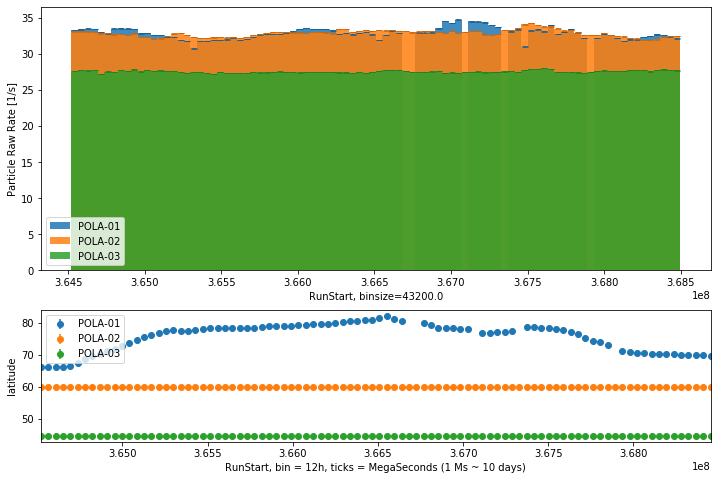

In [30]:
fig, ax = plt.subplots(2,  gridspec_kw={'height_ratios': [2., 1]})
plot_binned_raw_rate(ax[0], binned_raw_rate(runs, "RunStart", 60*60*12))
show_sorted_legend(ax[0])
ax[0].set_ylabel("Particle Raw Rate [1/s]");
binned_agg(runs, "RunStart", "latitude", np.mean, 60*60*12) \
    .groupby("telescope").apply(lambda df: \
                                df.reset_index(level=0).plot(y="latitude", yerr="latitude_err", ls="none", marker="o", ax=ax[1], label=df.index.get_level_values(0)[0]))
show_sorted_legend(ax[1])
ax[1].set_xlabel("RunStart, bin = 12h, ticks = MegaSeconds (1 Ms ~ 10 days)");
ax[1].set_ylabel("latitude");

In [31]:
def plot_hist(ax, runs, xlabel, binsize, tsc_order=None):
    if tsc_order is None:
        tsc_order = ["POLA-02", "POLA-03", "POLA-01"]
    
    bins = np.arange(runs[xlabel].values.min(), runs[xlabel].values.max() + binsize/2, binsize)
    for tsc in tsc_order:
        df_x = runs[runs["telescope"] == tsc][xlabel]
        ax.hist(df_x, bins=bins, alpha=0.8, color=tsc_color_map[tsc], label=tsc)
        
    ax.set_ylabel("Count")
    ax.set_xlabel(f"{xlabel}, binsize={binsize}")

In the histogram, for the POLA-01 detector we can't discover any explicit dependency on the latitude, although it changes in time.

We can observe dips in the histogram for POLA-01. To cross-check ourselves, let's plot number of runs per bin, because the guess is that we miss some data for POLA-01

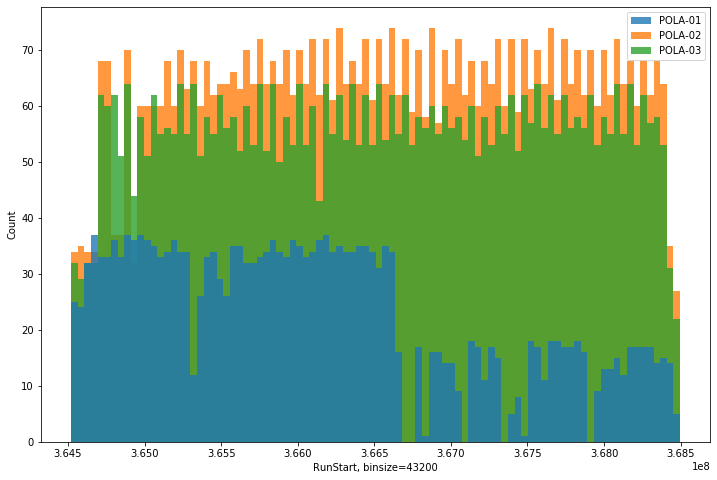

In [32]:
fig, ax = plt.subplots()
plot_hist(ax, runs, "RunStart", 60*60*12)
show_sorted_legend(ax)

Indeed, at the places where we had dips for the raw rate we observe missing data. Also we notice that there is signigicant reduction of data acquisition rate, which has happend in the middle of the experiment.

### 3.2.1 Longitude and latitude

In [33]:
def pivot_on_binned_time(df, xlabel, xagg, xagg_err, binsize, on="RunStart", ylabel="NumEvents", yagg=None, yagg_err=None):
    if yagg is None:
        yagg = lambda x: np.sum(x)/binsize
    if yagg_err is None:
        yagg_err = lambda x: np.sqrt(x.sum())/binsize
    binned_numevents = binned_agg(df, on, ylabel, yagg, binsize, agg_err=yagg_err)
    
    newx = binned_agg(df, on, xlabel, xagg, binsize, agg_err=xagg_err).reset_index(drop=False)
    return binned_numevents\
                .reset_index(drop=False) \
                .merge(newx, on=["telescope", on]) \
                .drop(columns=[on]) \
                .groupby("telescope") \
                .apply(lambda df: df.sort_values(["telescope", xlabel], axis=0)) \
                .set_index(["telescope"])

In [34]:
def plot_scatter_from_pivot(ax, pivot, xlabel, ylabel, xscale=1.):
    if not isinstance(ax, list):
        ax = itertools.repeat(ax)
    ax_iter = iter(ax)
    for tsc, ts in pivot.groupby(level=0):
        next(ax_iter).errorbar(ts[xlabel]/xscale,
                               ts[ylabel].values,
                               yerr=ts[f"{ylabel}_err"].values,
                               xerr=ts[f"{xlabel}_err"].values,
                               fmt="o",
                               capsize=2,
                               color=tsc_color_map[tsc],
                               label=tsc)

Here we also plot location of POLA-01 telescope in different time points. We average location of the telescope in the 12 h time interval, mostly for points to reproduce predictable timestamps but also to elimintate a bit of noise coming from the later times of the expedition for POLA-01. Also we see that two other telescopes stay still at the point of installement.

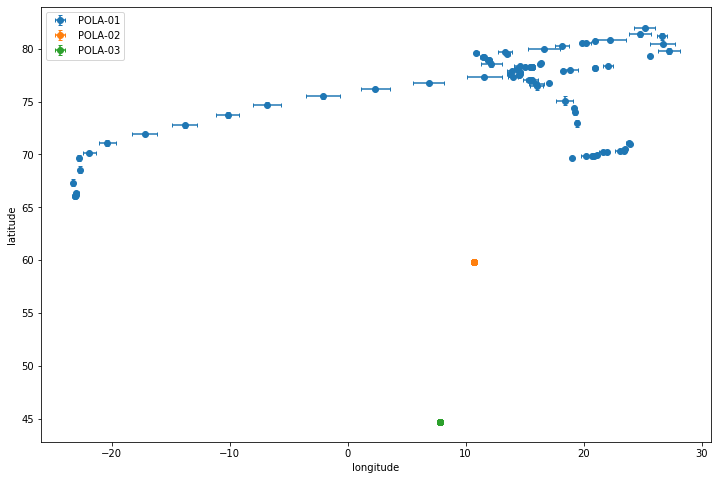

In [35]:
fig, ax = plt.subplots()
plot_scatter_from_pivot(ax,
                        pivot_on_binned_time(runs, "longitude", np.mean, np.std, 60*60*12, on="Seconds", ylabel="latitude", yagg=np.mean, yagg_err=np.std),
                        "longitude",
                        "latitude")
show_sorted_legend(ax)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude");

### Pressure and temperature

We try to plot scatter of the raw rate as a dependency of average pressure, where each point corresponds to a time range of 10 minutes. We apply cuts here, since dependency on time is not explicit, and noisy perturbation can't be eliminated by eye. As a result, there are two lines on each plot that can be observed. Also it is interesting that this additional line at ~60 events per second starts at some level in pressure, but the level is different for various telescopes. 

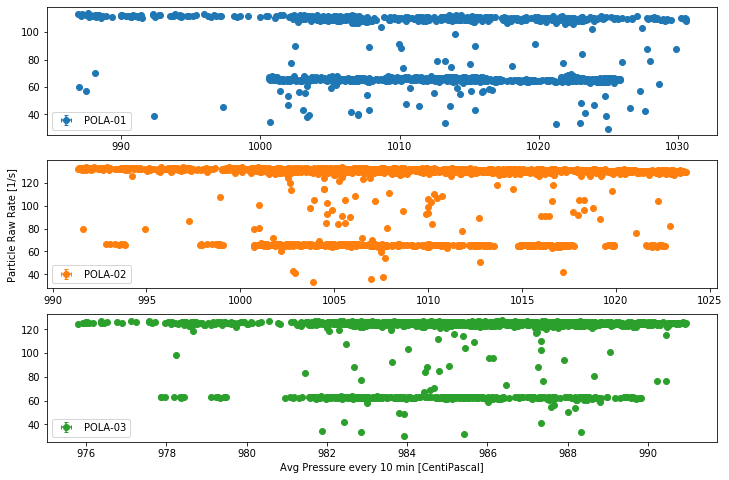

In [36]:
fig, ax = plt.subplots(3)
plot_scatter_from_pivot(list(ax),
                        pivot_on_binned_time(runs[~assemble_cuts(runs, ["runs.pola3_perturb_time",
                                                                        "runs.pola1_time_misses"])],
                                             "Pressure", np.mean, None, 60*10),
                        "Pressure",
                        "NumEvents",
                        xscale=1.)
show_sorted_legend(list(ax))
ax[2].set_xlabel("Avg Pressure every 10 min [CentiPascal]");
ax[1].set_ylabel("Particle Raw Rate [1/s]");

It was just a nice discovery which requires further investigation. But now, let's plot histograms for the raw rate depending on weather conditions. We start from `IndoorTemperature`. Again, errorbars are poissonian for the raw rate, and they are small. We have already seen this before.

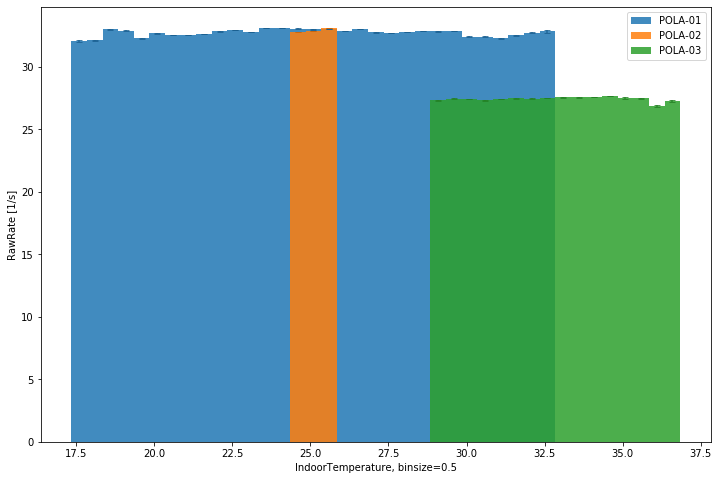

In [37]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs, "IndoorTemperature", 0.5))

We don't observe significant dependency of the raw rate on temperature, but we see explicit decreasing trend for its dependency on pressure (below).

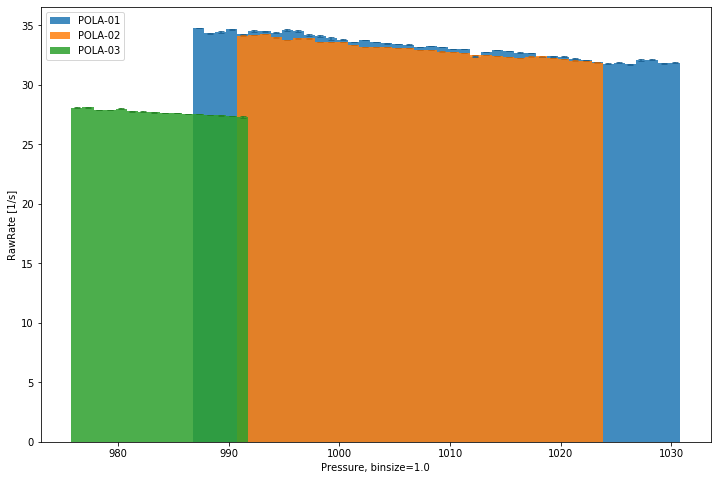

In [38]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs[~assemble_cuts(runs, ["runs.pola3_perturb_time"])], "Pressure", 1))

Before we try to fit the trend, let's standardize data from all telescopes. For this, we'll use correction coefficients that depend on the material roof top of the detectors made of.

In [39]:
ROOFTOP_CORRECTION = {
    "POLA-01": 1.,
    "POLA-02": 1.03,
    "POLA-03": 1.3
}

In [40]:
def rooftop_correct_runs(runs):
    res = []
    for tsc, df in runs.groupby("telescope"):
        df_copy = df.copy()
        df_copy.loc[:, ["NumEvents"]] = df_copy["NumEvents"].copy()*ROOFTOP_CORRECTION[tsc]
        res.append(df_copy)
    return pd.concat(res)

In [41]:
runs_with_cuts = runs[
                        ~assemble_cuts(runs, ["runs.pola3_perturb_time",
                                              "runs.pola1_time_misses"])
                     ]

We also apply cuts, to remove data from POLA-03 perturbed time range and also POLA-01 misses, otherwise they might introduce some noise. Finally, after cleaning up and rescaling we end up with very beautiful dependency of the raw rate measured by telescopes as a function of pressure.

In [42]:
rooftop_correct_with_cuts = rooftop_correct_runs(runs_with_cuts)

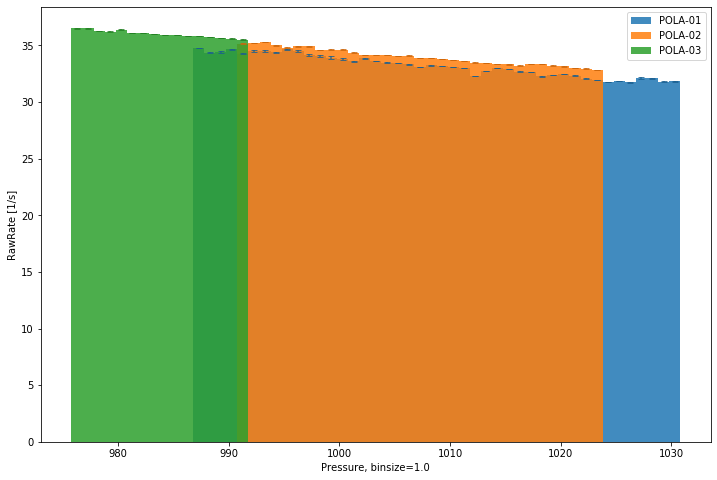

In [43]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(rooftop_correct_with_cuts, "Pressure", 1.))

To fit this trend, we will use exponential model: $\gamma(p) \propto e^{a + b(p - p_{ref})}$. Here, reference pressure should depend on the telescope, but parameter $b$ of the model we treat as a universal parameter. (we have already corrected for the rooftop material and checked that there are no other obious dependencies on other factors).

In [44]:
REFERENCE_PRESSURE = {
    "POLA-01": 1011.85,
    "POLA-02": 1008.53,
    "POLA-03": 985.87
}

In [45]:
def expfit_pressure(runs):
    tscdf = binned_raw_rate(runs, "Pressure", 1.).reset_index(drop=False)
    log_numevents = np.log(tscdf[["NumEvents"]]).rename(columns={"NumEvents": "log_NumEvents"})
    pressure = tscdf[["telescope", "Pressure"]].copy()
    for tsc, p_ref in REFERENCE_PRESSURE.items():
        mask = pressure["telescope"] == tsc
        pressure.loc[mask, "Pressure"] = pressure[mask]["Pressure"] - p_ref
    pressure.rename(columns={"Pressure": "Pressure_from_ref"}, inplace=True)
        
    model = smfa.wls("log_NumEvents ~ Pressure_from_ref", data=pd.concat([log_numevents, pressure], axis=1),
                     weights=tscdf["NumEvents"]/tscdf["NumEvents_err"]).fit()
    return model

In [46]:
expfit_model = expfit_pressure(rooftop_correct_with_cuts)
expfit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          log_NumEvents   R-squared:                       0.233
Model:                            WLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     27.64
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           9.58e-07
Time:                        17:37:43   Log-Likelihood:                 176.62
No. Observations:                  93   AIC:                            -349.2
Df Residuals:                      91   BIC:                            -344.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.5292      0.003   1027.602      0.000       3.522       3.536
Pressure_from_ref    -0.0022      0.000     -5.258      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       29.823   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.140
Skew:                           1.530   Prob(JB):                     2.60e-10
Kurtosis:                       4.426   Cond. No.                         8.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary of the fitted model we discover that $b$, that is the coefficient close to `Pressure_from_ref` and denoted as the latter in summary, shows very high significance and we can rely on it as a universal parameter for the model.

Now, when we've got $b$, let's correct `NumEvents` making use of barometric coefficient $\gamma$. We will divide each value of `NumEvents` by the one predicted by our exponential model (we will ignore `intercept` prefactor, because only dependency on pressure makes sense here. Common constant will just normalize average level to unity) 

In [47]:
def correct_num_events_for_pressure(runs, expfit_model):
    pressure_coef = expfit_model.params["Pressure_from_ref"]
    df = runs.copy()
    for tsc in np.unique(df["telescope"]):
        ref_pressure = REFERENCE_PRESSURE[tsc]
        mask = df["telescope"] == tsc
        tsc_df = df[mask]
        df.loc[mask, "NumEvents"] = tsc_df["NumEvents"]/np.exp(
            (tsc_df["Pressure"] - ref_pressure) * pressure_coef
        )
    return df

In [48]:
runs_corrected_pressure = correct_num_events_for_pressure(rooftop_correct_with_cuts, expfit_model)

Let's have a look on the raw rate dependency on pressure after barometric correction has been applied:

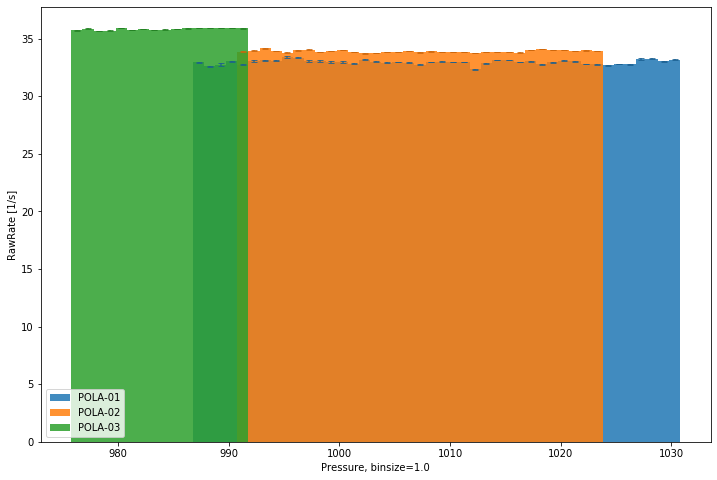

In [49]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs_corrected_pressure, "Pressure", 1.))

After barometric correction has been applied, we see that distributions from all telescopes got flattened. At the same time, we observe explicit excess in raw rate for POLA-03. The reason for this is the reference pressure for POLA-03, that is far aside of the one for POLA-01 and POLA-02, while the raw rate for all 3 detectors lies on the same linear (or exponential trend) without any shifts. Since reference pressure is a phenomenological parameter, we question its reliability in this study.

We might also be interested in the dependency of the corrected raw rate on time

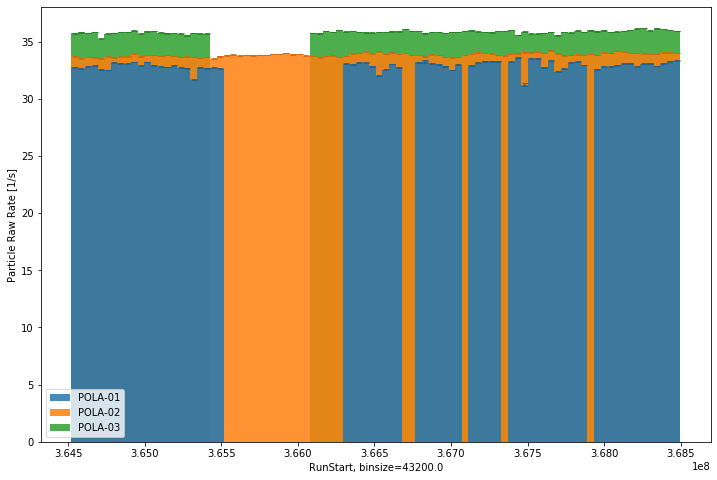

In [50]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax, binned_raw_rate(runs_corrected_pressure, "RunStart", 60*60*12), ["POLA-03", "POLA-02", "POLA-01"])
show_sorted_legend(ax)
ax.set_ylabel("Particle Raw Rate [1/s]");

After barometric correction dependency on time became indeed more flat, there are much fewer dips and bumps in POLA-01 distribution, and their amplitude became smaller. We of course still observe over amplification of the POLA-03 data. Also cuts we applied before in the noisy time ranges are visible here explicitly.

### 3.3 Raw rate as a function of latitude

Below we show two plots for comparison. On the first plot we show dependency of the raw rate corrected for roof top materials and with time-range cuts applied at the places of perturbation. On the second plot we show the same dependency but for the data being corrected for pressure effects.

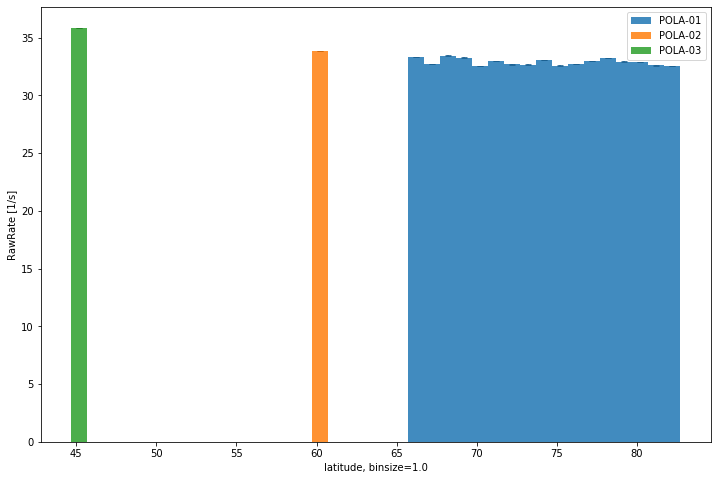

In [51]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(rooftop_correct_with_cuts, "latitude", 1))

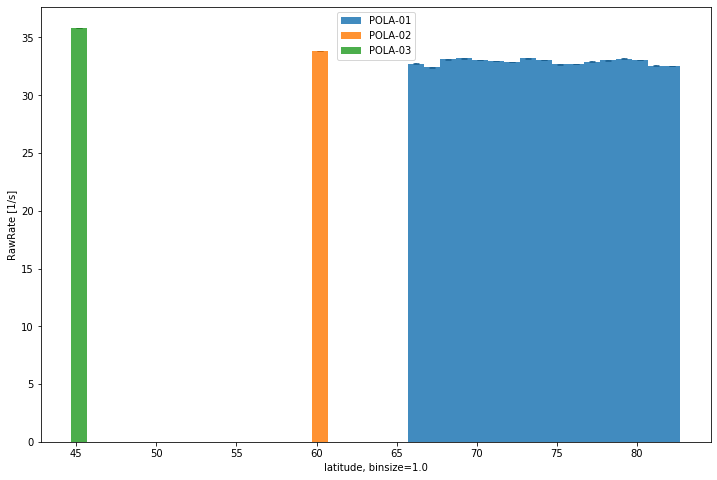

In [52]:
fig, ax = plt.subplots()
plot_binned_raw_rate(ax,
                     binned_raw_rate(runs_corrected_pressure, "latitude", 1))

When comparing to the plot from the Compton's publication, we see the reverse dependency, that in the intermediate latitudes (\~45°) raw rate is higher than the one saturated at high pressures. From the Compton's fit we could expect that (\~45°) is a transition region, very close to the saturated value, so the value there should be comparable to the saturated one, or at least shifted a bit lower. At the same time, scatter of the results around the bin 45° is quite high, so the fit that Compton referes to might be imprecise.

If the reference pressure used for POLA-03 was comparable to those for POLA-02 and POLA-01, we would discover almost flat distribution, thus no dependency on the latitude in in this region could be claimed.